In [ ]:



# Use the same preprocessing as for the ResNet model


image = resize_transform(Image.open(img_path)).unsqueeze(0)
image = image.cuda()

# Get the predicted class
output = model(image)
_, predicted_class = torch.max(output, 1)

# Use GradCAM
targets = [ClassifierOutputTarget(predicted_class[0])]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_cam = cam(input_tensor=image, targets=targets)
visualization = show_cam_on_image(raw_image, grayscale_cam[0, :])

# Save the result
output_path = "home/student/Desktop/31171109-donotdelete/xai-chan/explanation/explanation/cam.png"
cv2.imwrite(output_path, np.uint8(255 * visualization))


In [2]:
%pip install pytorch-grad-cam

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch

from PIL import Image

import os
import sys
import numpy as np

from PIL import Image
import torch


# Append custom paths to sys.path for importing custom modules
sys.path.append(os.path.dirname("/home/student/Desktop/31171109-donotdelete/xai-chan/utils"))
from utils.models import ResNet_Model
from utils.transform import resize_transform

# Initialize device
device = torch.device('cuda:0')
# Load the model
version = 50
model = ResNet_Model(version=version).to(device)
weights_path = "/home/student/Desktop/31171109-donotdelete/xai-chan/result/imagenet/_Fold_0_5_100X_BreakHis_FT_60_resnet50_imagenet_/_97_94.94949494949495_95.2628090863385_0.9500590562820435.pth"  # TODO: Provide the model path
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

/home/student/anaconda3/envs/xai-chan/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/anaconda3/envs/xai-chan/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [13]:
targets = [ClassifierOutputTarget(0)]
# Define the target layer
target_layer = [model.model.layer4[-1]]
print(target_layer)

image_path ="/home/student/Desktop/31171109-donotdelete/xai-chan/dataset/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-001.png"
input_rgb = Image.open(image_path)
width, height = input_rgb.size
input_tensor = resize_transform(np.array(input_rgb)).unsqueeze(0).to(device)

# Convert to NumPy array if it's not already
if not isinstance(input_rgb, np.ndarray):
    input_rgb = np.array(input_rgb)

# Normalize to [0, 1]
input_rgb = input_rgb.astype(np.float32) / 255.0

cam = GradCAM(model=model.model, target_layers=target_layer, use_cuda=True)
#cam = cam.to(device)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
grayscale_cam_resized = cv2.resize(grayscale_cam, (input_rgb.shape[1], input_rgb.shape[0]))
visualization = show_cam_on_image(input_rgb, grayscale_cam_resized, use_rgb=True)


from PIL import Image
Image.fromarray(visualization).save("/home/student/Desktop/31171109-donotdelete/xai-chan/explanation/explanation/cam.png")


[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


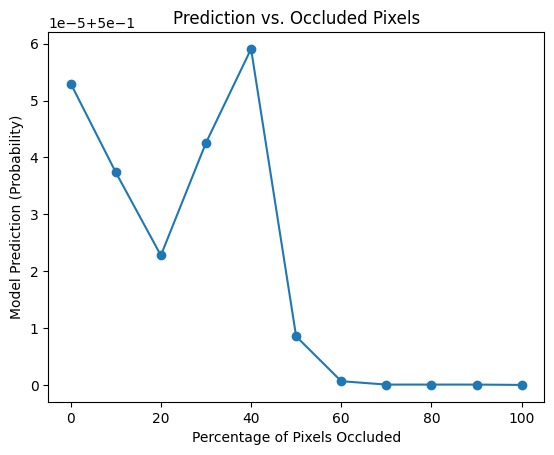

In [14]:
import matplotlib.pyplot as plt
# Flatten and sort the heatmap values
sorted_indices = np.argsort(-grayscale_cam_resized.flatten())

steps = np.linspace(0, 1, 11)
predicted_probs = []

for step in steps:
    num_pixels_to_occlude = int(step * np.prod(input_tensor.shape[2:]))
    indices_to_occlude = sorted_indices[:num_pixels_to_occlude]
    occluded_image = input_tensor.clone().view(-1)
    occluded_image[indices_to_occlude] = occluded_image.mean()
    occluded_image = occluded_image.view(input_tensor.shape)

    with torch.no_grad():
        prediction = torch.sigmoid(model(occluded_image)).item()
    predicted_probs.append(prediction)

plt.plot(steps * 100, predicted_probs, '-o')
plt.xlabel('Percentage of Pixels Occluded')
plt.ylabel('Model Prediction (Probability)')
plt.title('Prediction vs. Occluded Pixels')
plt.show()

In [15]:
import numpy as np

def compute_aoc(heatmap):
    # Flatten the heatmap
    flat_heatmap = heatmap.flatten()
    
    # Sort the flattened heatmap in descending order
    sorted_heatmap = np.sort(flat_heatmap)[::-1]
    
    # Compute the cumulative sum
    cum_sum = np.cumsum(sorted_heatmap)
    
    # Normalize the cumulative sum
    normalized_cum_sum = cum_sum / cum_sum[-1]
    
    # Compute the AOC (area over the curve)
    aoc = np.sum(normalized_cum_sum) / len(normalized_cum_sum)
    
    return aoc

# For your heatmap
aoc_value = compute_aoc(grayscale_cam_resized)
print(f"AOC for Grad-CAM: {aoc_value:.4f}")


AOC for Grad-CAM: 0.9542


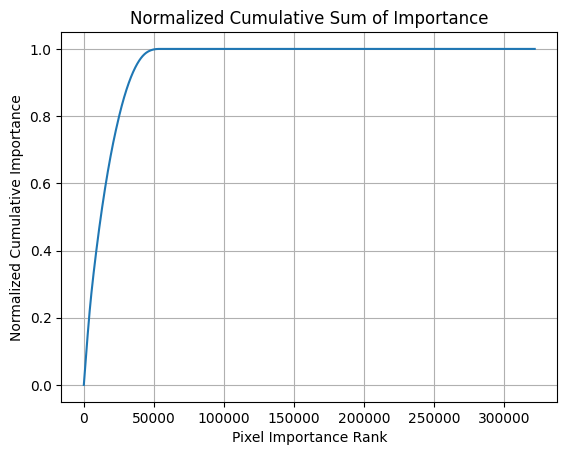

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_normalized_cumulative_sum(heatmap):
    # Flatten the heatmap
    flat_heatmap = heatmap.flatten()
    
    # Sort the flattened heatmap in descending order
    sorted_heatmap = np.sort(flat_heatmap)[::-1]
    
    # Compute the cumulative sum
    cum_sum = np.cumsum(sorted_heatmap)
    
    # Normalize the cumulative sum
    normalized_cum_sum = cum_sum / cum_sum[-1]
    
    # Plot
    plt.plot(normalized_cum_sum)
    plt.xlabel('Pixel Importance Rank')
    plt.ylabel('Normalized Cumulative Importance')
    plt.title('Normalized Cumulative Sum of Importance')
    plt.grid(True)
    plt.show()

# For your heatmap
plot_normalized_cumulative_sum(grayscale_cam_resized)
